# Clustering answers

We cluster the most frequently annotated answers by category and plot them in a 2D graph.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5, "lines.markersize": 8})

%matplotlib inline

In [13]:
clusters = {
    "Body part": {"fingers", "hair", "hand", "head", "her feet", "her head", "his body", "his hands", "legs"},
    "Material": {"carpet", "cloth", "dirt", "fire", "grass", "ice", "liquid", "metal", "paper", "pond", "rock", "sand",
                  "snow", "steel", "wall", "wood"},
    "Object": {"animal", "ball", "baseball", "bed", "board", "bowl", "brush", "camera", "car", "chair", "container", "desk", "device", "dish", "dish", "equipment", "food",
                "glasses", "hill", "instrument", "it", "item", "liquid", "machine", "musical instrument", "object", "pan", "pole", "shoes", "something", "stick", "table","thing", "tool", "toy",
                "tree", "tube", "tube", "water"},
    "Other": {"bunch", "competition", "game", "line", "music", "other", "piece", "song", "lot"},
    "Person-related": {"adult", "another person", "artist", "athlete", "audience", "baby", "band", "boy", "chef", "child", "children", "competitors",
                       "couple", "crowd", "dancer", "daughter", "dude", "employee", "father", "female", "friend", "gentleman", "group", "group of people", "girl", "guy", "he",
                       "herself", "host", "human", "humans", "individual", "infant", "instructor", "kid", "kids", "lady", "little girl", "male", "man", "mother", "musician", "old man", "other people", "performer",
                       "person", "people", "player", "she", "siblings", "some dude", "some guy", "somebody", "someone", "son", "spectators", "student", "teacher", "team", "teen", "teenager", "they", "toddler", "trainer", "viewers", "woman", "worker", "workers", "young boy", "young child", "young girl", "young man", "young woman", "youngster", "youth"},
    "Place": {"background", "backyard", "building", "class", "courtyard", "field", "floor", "ground", "gym", "his house", "home", "house", "kitchen",
              "living room", "mountain", "park", "pavement", "room", "stage", "street", "studio", "video"},
    "Position": {"bottom", "back", "front", "left", "right", "side", "top"},
}  # The phrases here include the answers of interest that are computed hereafter.

cluster_by_answer = {v: k for k, values in clusters.items() for v in values}

In [3]:
import json

from lqam.methods.dataset import URL_DATA_TEST, URL_DATA_VAL
from lqam.util.file_utils import cached_path

with open(cached_path(URL_DATA_VAL)) as file:
    val_data = json.load(file)

with open(cached_path(URL_DATA_TEST)) as file:
    test_data = json.load(file)

instances = val_data + test_data

In [6]:
from tqdm.auto import tqdm

from lqam.core.noun_phrases import create_spacy_model
from lqam.core.metrics import normalize_answer

spacy_model = create_spacy_model()

# If one answer occurs multiple times for one blanked caption, we count it only once.

answer_list = []

for instance in tqdm(instances):
    unique_instance_answers = set()
    for worker_answers in instance["additional_answers"]:
        for answer_doc in spacy_model.pipe(normalize_answer(answer) for answer in worker_answers):
            if len(answer_doc) == 1:
                answer = answer_doc[0].lemma_
            else:
                answer = answer_doc.text
            unique_instance_answers.add(answer)
    answer_list.extend(unique_instance_answers)

answer_counts = pd.Series(answer_list).value_counts()

answer_counts.head(15)

  0%|          | 0/1985 [00:00<?, ?it/s]

person     416
man        353
guy        271
someone    226
kid        200
woman      188
girl       181
boy        179
child      171
people     152
lady       136
male       129
adult       93
group       90
friend      89
dtype: int64

In [19]:
answers = answer_counts.head(100).keys().tolist()

In [15]:
from sentence_transformers import SentenceTransformer

embeddings = SentenceTransformer("stsb-roberta-base").encode(answers)
embeddings /= np.linalg.norm(embeddings, axis=1, keepdims=True)
embeddings.shape

(100, 768)

In [16]:
color_by_cluster = {name: color for name, color in zip(clusters, sns.color_palette("hls", n_colors=len(clusters)))}

In [17]:
from sklearn.manifold import TSNE

embeddings_2d = TSNE(n_components=2, init="random", learning_rate="auto").fit_transform(embeddings)

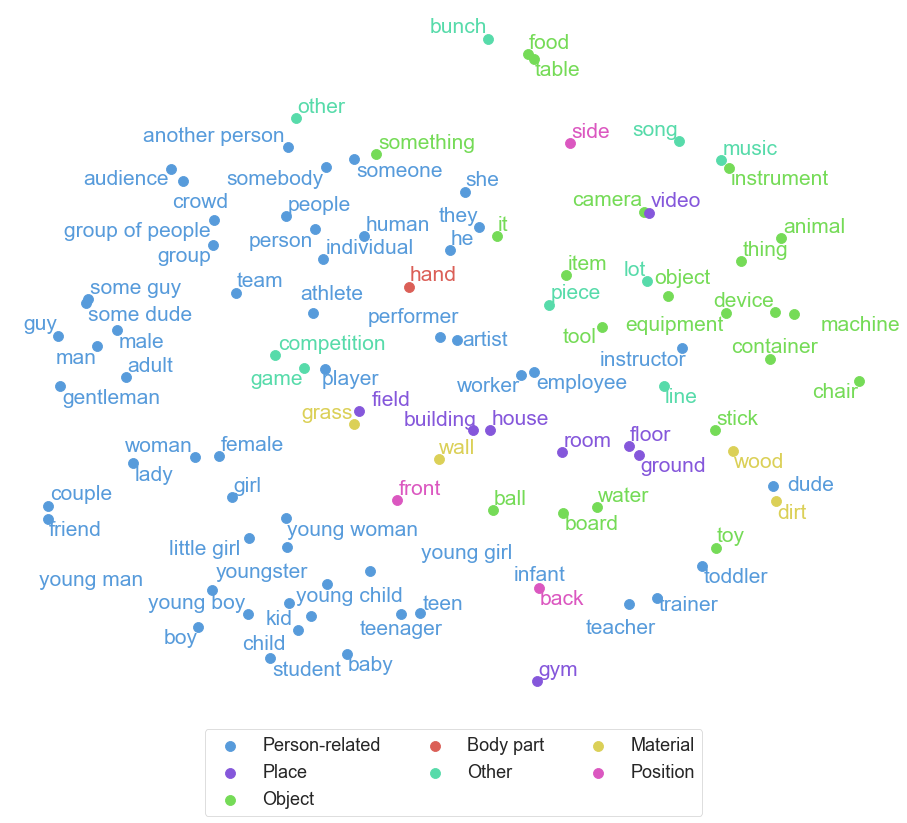

In [24]:
from collections import defaultdict

from adjustText import adjust_text

plt.figure(figsize=(16, 13))

points_by_cluster = defaultdict(list)

for answer, (x, y) in zip(answers, embeddings_2d):
    cluster_name = cluster_by_answer[answer]
    plt.scatter(x, y, color=color_by_cluster[cluster_name], s=100,
                label=None if cluster_name in points_by_cluster else cluster_name)
    points_by_cluster[cluster_name].append((x, y, answer))

adjust_text([plt.text(x, y, answer, ha="right", va="bottom", size=21, color=color_by_cluster[cluster_name], wrap=True)
             for cluster_name, points in points_by_cluster.items()
             for x, y, answer in points])

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.01), ncol=len(clusters) // 2, prop={"size": 18})

plt.yticks([])
plt.xticks([])

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)

plt.gcf().savefig("clusters.pdf", bbox_inches="tight")